In [8]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.special import kv, kvp, gamma
from tqdm import tqdm

from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats

In [168]:
# Copied the bits I need from Aurelien
from scipy.special import kv, kvp, gamma

def matern32_d1(dx, eta, l):
    """Matern 3/2 function, first derivative"""
    
    cff0 = np.sqrt(3)/l
    cff1 = cff0*np.abs(dx)
    Kp = -np.power(eta, 2.)*cff0*cff1*np.exp(-cff1)
    
    return Kp

def matern32_d2(dx, eta, l):
    """Matern 3/2 function, second derivative"""
    
    cff0 = np.sqrt(3)/l
    cff1 = cff0*np.abs(dx)
    Kpp = np.power(eta, 2.) * cff0**2 *(-1+cff1)*np.exp(-cff1)
    
    return Kpp

Ct = cov.matern12

def Cu(x, y, d, λ):
    C = -(
        y**2 * matern32_d2(d, 1., λ)
        + x**2 * matern32_d1(d, 1., λ) / d
    )/ d**2
    C[np.isnan(C)] = -matern32_d2(d[np.isnan(C)], 1.0, λ)
    return C

def Cv(x, y, d, λ):
    C = -(
        x**2 * matern32_d2(d, 1., λ)
        + y**2 * matern32_d1(d, 1., λ) / d
    ) / d**2
    C[np.isnan(C)] = -matern32_d2(d[np.isnan(C)], 1.0, λ)
    return C

def Cuv(x, y, d, λ):
    C = x*y*(
            matern32_d2(d, 1., λ)
            - matern32_d1(d, 1., λ) / d
        ) / d**2
    C[np.isnan(C)] = 0.
    return C

def kernel_3d_iso_uv(x, xpr, params):
    """
    3D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    n = x.shape[0]//2
    _x = x[:n,0,None] - xpr.T[:n,0,None].T
    _y = x[:n,1,None] - xpr.T[:n,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )

    C = np.ones((2*n,2*n))
    C[:n,:n] *= Cu(_x, _y, _d, ld)
    C[:n,n:] *= Cuv(_x, _y, _d, ld)
    C[n:,:n] = C[:n,n:]
    C[n:,n:] *= Cv(_x, _y, _d, ld)
    C *= Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= eta**2
    
    return C

In [170]:
nc_file = "data/3D_matern32_iso_matern12_pp_r0.0_u0.2_drifter_preinference_f1.10.nc"
# nc_file = "data/3D_matern32_iso_matern12_pp_r0.0_u0.2_drifter_preinference_Nxy1_f1.10.nc"

ds = xr.open_dataset(nc_file)
X = ds.X.values
U = ds.U.values[:,None]
noise = ds.attrs["noise"]
# Amplitude, spatial scale, time scale
covparams = [ds.attrs[f"covparams{i}"] for i in range(3)]

## Get MCMC working

### Parameterise the MCMC chains

In [216]:
# The order of everything is eta, ld, lt, noise
n_mcmc = int(2e3)

step_sizes = np.array([.5, 5, .5, 0.005])
initialisations = np.array([12, 100, 5, 0.01])
lowers = np.repeat(0, 4)
uppers = np.array([100, 1000, 100, 0.05])

### Set up objects

In [217]:
eta_samples = np.empty(n_mcmc)
ld_samples = np.empty(n_mcmc)
lt_samples = np.empty(n_mcmc)
noise_samples = np.empty(n_mcmc)
accept_samples = np.empty(n_mcmc)

eta_samples[0] = initialisations[0]
ld_samples[0] = initialisations[1]
lt_samples[0] = initialisations[2]
noise_samples[0] = initialisations[3]
accept_samples[0] = 0

covparams_curr = initialisations.copy()[0:3]
covparams_prop = initialisations.copy()[0:3]

### Run MCMC

In [218]:
gp_current = GPtideScipy(X, X, noise, kernel_3d_iso_uv, covparams)

for i in tqdm(np.arange(1, n_mcmc)):
    
    eta_proposed = np.random.normal(eta_samples[i-1], step_sizes[0], 1)
    ld_proposed = np.random.normal(ld_samples[i-1], step_sizes[1], 1)
    lt_proposed = np.random.normal(lt_samples[i-1], step_sizes[2], 1)
    noise_proposed = np.random.normal(noise_samples[i-1], step_sizes[3], 1)

    proposed = np.array([eta_proposed, ld_proposed, 
                         lt_proposed, noise_proposed])

    if ((proposed.T <= lowers) | (proposed.T >= uppers)).any():
        eta_samples[i] = eta_samples[i-1]
        ld_samples[i] = ld_samples[i-1]
        lt_samples[i] = lt_samples[i-1]
        noise_samples[i] = noise_samples[i-1]
        accept_samples[i] = 0
        continue

    if accept_samples[i-1] == True:
        gp_current = gp_proposed
    
    covparams_prop = np.array([eta_proposed, ld_proposed, lt_proposed])
    gp_proposed = GPtideScipy(X, X, noise_proposed, kernel_3d_iso_uv, covparams_prop)

    lp_current = gp_current.log_marg_likelihood(U)
    lp_proposed = gp_proposed.log_marg_likelihood(U)

    alpha = np.min([1, np.exp(lp_proposed - lp_current)])
    u = np.random.uniform()

    if alpha > u:
        eta_samples[i] = eta_proposed
        ld_samples[i] = ld_proposed
        lt_samples[i] = lt_proposed
        noise_samples[i] = noise_proposed
        accept_samples[i] = 1
    else:
        eta_samples[i] = eta_samples[i-1]
        ld_samples[i] = ld_samples[i-1]
        lt_samples[i] = lt_samples[i-1]
        noise_samples[i] = noise_samples[i-1]
        accept_samples[i] = 0

/var/folders/3j/vx_555_s2kndspggbdjv518cf7gn8m/T/ipykernel_69346/2863716993.py:27: RuntimeWarning: invalid value encountered in divide
  + x**2 * matern32_d1(d, 1., λ) / d
/var/folders/3j/vx_555_s2kndspggbdjv518cf7gn8m/T/ipykernel_69346/2863716993.py:43: RuntimeWarning: invalid value encountered in divide
  - matern32_d1(d, 1., λ) / d
/var/folders/3j/vx_555_s2kndspggbdjv518cf7gn8m/T/ipykernel_69346/2863716993.py:35: RuntimeWarning: invalid value encountered in divide
  + y**2 * matern32_d1(d, 1., λ) / d
  0%|          | 0/1999 [00:00<?, ?it/s]/var/folders/3j/vx_555_s2kndspggbdjv518cf7gn8m/T/ipykernel_69346/686483375.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eta_samples[i] = eta_proposed
/var/folders/3j/vx_555_s2kndspggbdjv518cf7gn8m/T/ipykernel_69346/686483375.py:35: DeprecationWarning: Conversion of 

In [219]:
print(np.mean(accept_samples))

0.309


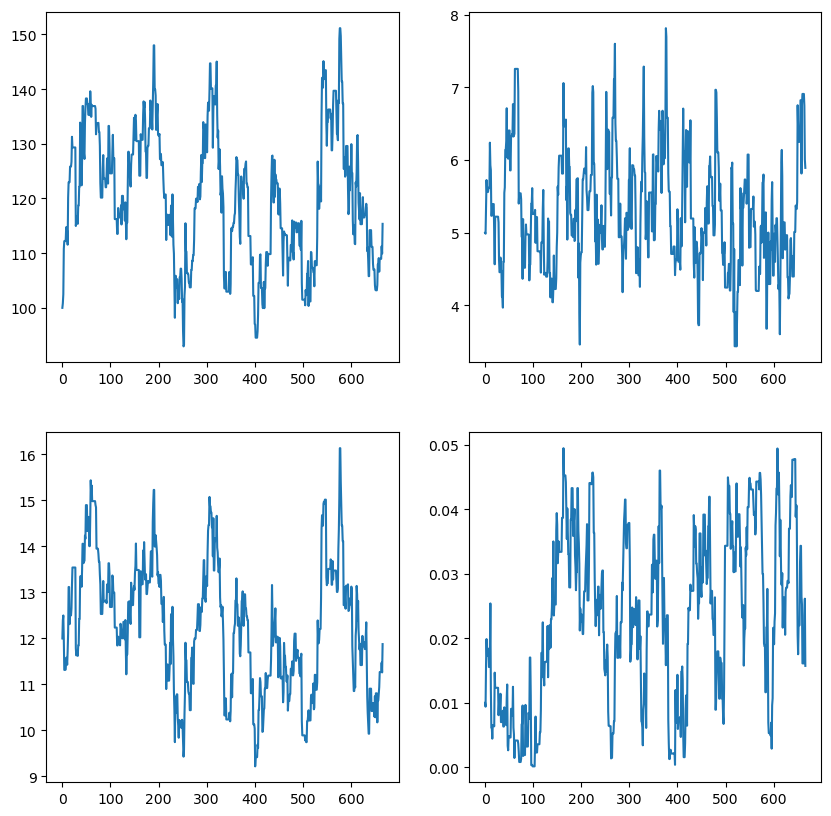

In [220]:
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.plot(ld_samples[0::3])

plt.subplot(222)
plt.plot(lt_samples[0::3])

plt.subplot(223)
plt.plot(eta_samples[0::3])

plt.subplot(224)
plt.plot(noise_samples[0::3])